In [1]:
import numpy as np
import pandas as pd




%load_ext autoreload
%autoreload

## Load external data

In [2]:
freq = 'w'
risk_profile = 2

#### Prices

In [3]:
filepath = '../../data/external/'
filename = 'price_db_' + freq + '.pkl'
price_db = pd.read_pickle(filepath+filename)

Make `df_rt`, a matrix of log returns of all eligible **instruments** in the universe with:
- Columns: itemcode
- Rows: date

In [10]:
df_rt = price_db[price_db.itemtype=='ETF'].pivot(index='date', columns='itemcode', values='ret').dropna()

In [11]:
df_price

itemcode,A069500,A091160,A091170,A091180,A102110,A102780,A105190,A114260,A122260,A130730,...,A214980,A229200,A232080,A245340,A245710,A251350,A266370,A273130,A278540,A283580
date,,,,,,,,,,,,,,,,,,,,,
2017-12-15,30640.0,26245.0,7956.0,15975.0,30392.0,6547.0,30768.0,54015.0,95754.0,96399.0,...,98227.0,12941.0,13007.0,12851.0,13630.0,12185.0,12288.0,99640.0,9565.0,9980.0
2017-12-22,30152.0,26304.0,8074.0,15824.0,29918.0,6393.0,30369.0,53927.0,95745.0,96418.0,...,98251.0,12926.0,12973.0,12937.0,13740.0,12225.0,12074.0,99535.0,9400.0,10165.0
2017-12-28,30762.0,26901.0,8184.0,16405.0,30541.0,6595.0,30979.0,53996.0,95797.0,96452.0,...,98271.0,13864.0,13895.0,12808.0,13930.0,12145.0,12391.0,99495.0,9670.0,10045.0
2018-01-05,31203.0,26568.0,8350.0,15782.0,30940.0,6782.0,31322.0,54005.0,95883.0,96509.0,...,98335.0,14452.0,14490.0,12823.0,14540.0,12335.0,12742.0,99490.0,9825.0,10335.0
2018-01-12,30982.0,25711.0,8783.0,15701.0,30755.0,6864.0,31181.0,53927.0,95902.0,96547.0,...,98384.0,16056.0,16149.0,13094.0,15295.0,12445.0,12352.0,99300.0,9850.0,10540.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-05,42950.0,35585.0,6275.0,26395.0,42790.0,10500.0,43250.0,58155.0,101115.0,100920.0,...,102950.0,14945.0,15035.0,17610.0,16195.0,17270.0,22145.0,109785.0,13815.0,15145.0
2021-02-10,42680.0,35570.0,6420.0,25115.0,42515.0,10455.0,42935.0,58165.0,101135.0,100930.0,...,102975.0,14770.0,14865.0,17515.0,15830.0,17330.0,22005.0,109690.0,13745.0,15705.0
2021-02-19,42780.0,37080.0,6345.0,24390.0,42605.0,10420.0,43070.0,58175.0,101150.0,100950.0,...,102980.0,14525.0,14590.0,17515.0,16495.0,17240.0,22355.0,109585.0,13770.0,15745.0


## Load portfolio constraints

In [896]:
import riskfolio.ConstraintsFunctions as cf
import utils

#### Load asset classification and constraints information
- `asset_classes` <- `universe` <- tradable_instruments.pkl left join with instruments_m.pkl
- `constraints` <- constraints.pkl

In [897]:
filepath = '../../data/processed/'
filename = 'instruments_m.pkl'
instruments_m = pd.read_pickle(filepath+filename)

In [898]:
filepath = '../../data/external/'
filename = 'tradable_instruments.pkl'
tradable_instruments = pd.read_pickle(filepath+filename)

In [899]:
universe = pd.merge(tradable_instruments, instruments_m, left_on='itemcode', right_on='itemcode', how='left')

In [900]:
asset_classes = utils.get_asset_classes(universe)

In [901]:
filepath = '../../data/processed/'
filename = 'constraints.pkl'
df_constraints = pd.read_pickle(filepath+filename)

#### Remove strategy constraints for now.

In [902]:
df_constraints = df_constraints.drop(df_constraints[df_constraints.Set=='Strategy'].index)
# df_constraints = df_constraints.drop(df_constraints[df_constraints.Set=='DC risky asset'].index)

In [903]:
constraints = df_constraints[np.logical_or(
    df_constraints.risk_profile == str(risk_profile), df_constraints.risk_profile == 'Common')].drop(['risk_profile'], axis=1)

In [904]:
# constraints.drop(constraints[constraints.index>=2].index)

#### We have constraints matrice `A` and `B` such that
- $Aw \ge B$.

In [905]:
constraints

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,All Classes,Asset class,Equity,>=,0.20,NaN,NaN,NaN,NaN
10,False,All Assets,NaN,NaN,<=,0.25,NaN,NaN,NaN,NaN
11,True,Classes,DC risky asset,Y,>=,0.40,NaN,NaN,NaN,NaN
12,True,Classes,Issuer,KINDEX,<=,0.60,NaN,NaN,NaN,NaN
13,True,Classes,Issuer,KODEX,<=,0.60,NaN,NaN,NaN,NaN
14,True,Classes,Issuer,TIGER,<=,0.60,NaN,NaN,NaN,NaN
15,True,Classes,Issuer,KBSTAR,<=,0.60,NaN,NaN,NaN,NaN
16,True,Classes,Issuer,KOSEF,<=,0.60,NaN,NaN,NaN,NaN
17,True,Classes,Issuer,ARIRANG,<=,0.60,NaN,NaN,NaN,NaN
18,True,Classes,Issuer,HANARO,<=,0.60,NaN,NaN,NaN,NaN


In [906]:
A, B = cf.assets_constraints(constraints, asset_classes)

## Estimaing mean risk portfolios

- Using ***CDaR*** instead of variance as a risk measure.
  - Conditional Drawdown at Risk(CDaR) is the average drawdown for all the instances that drawdown **exceeded** a certain threshold. Drawdown is a measure of downside risk.
  - https://breakingdownfinance.com/finance-topics/alternative-investments/conditional-drawdown-at-risk-cdar/

In [907]:
import riskfolio.Portfolio as pf
import datetime

`y` is a matrix of log returns of all eligible instruments in the universe.

In [908]:
current_date = '2020-03-10'
y = df_rt[df_rt.index <= current_date]

In [909]:
df_rf = price_db[price_db.itemtype=='riskfree'].set_index('date', drop=True)
current_idx = df_rf.index.asof(datetime.datetime.strptime(current_date, '%Y-%m-%d'))
rf = df_rf.loc[current_idx].price  # risk free rate

#### Set a log-return matrix `y`

In [910]:
port = pf.Portfolio(returns=y) 

#### Set estimating methods
- `method_mu` to estimate expected returns.
- `method_cov` to estimated a covariance matrix.

In [926]:
method_mu='hist'  # Method to estimate expected returns; ewma with adjust=True. See pandas.DataFrame.ewm for more details.
method_cov='hist' # Method to estimate covariance matrix; ewma with adjust=True
decay=0.94

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=decay)

You must convert self.cov to a positive definite matrix


#### Apply constraints

In [927]:
port.ainequality = A
port.binequality = B

In [928]:
# Estimate optimal portfolio:
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'CVaR' # Risk measure used, this time will be variance
obj = 'MinRisk' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
l=0

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

In [929]:
constraints

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,All Classes,Asset class,Equity,>=,0.20,NaN,NaN,NaN,NaN
10,False,All Assets,NaN,NaN,<=,0.25,NaN,NaN,NaN,NaN
11,True,Classes,DC risky asset,Y,>=,0.40,NaN,NaN,NaN,NaN
12,True,Classes,Issuer,KINDEX,<=,0.60,NaN,NaN,NaN,NaN
13,True,Classes,Issuer,KODEX,<=,0.60,NaN,NaN,NaN,NaN
14,True,Classes,Issuer,TIGER,<=,0.60,NaN,NaN,NaN,NaN
15,True,Classes,Issuer,KBSTAR,<=,0.60,NaN,NaN,NaN,NaN
16,True,Classes,Issuer,KOSEF,<=,0.60,NaN,NaN,NaN,NaN
17,True,Classes,Issuer,ARIRANG,<=,0.60,NaN,NaN,NaN,NaN
18,True,Classes,Issuer,HANARO,<=,0.60,NaN,NaN,NaN,NaN


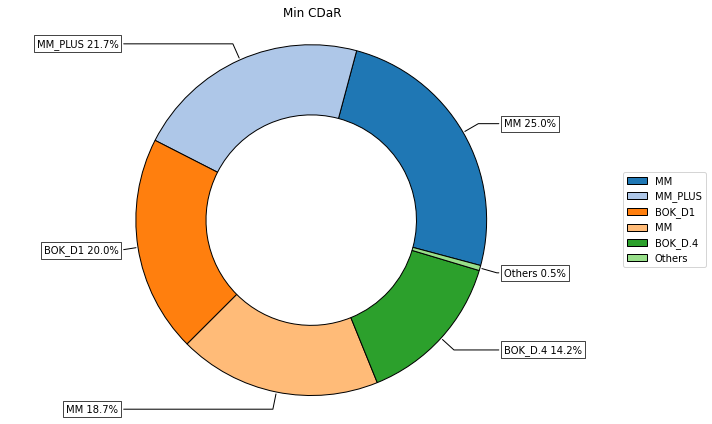

In [930]:
w = pd.merge(w, universe.loc[:,['itemcode', 'tracking_code']], left_index=True, right_on='itemcode', how='left')
w = w[['weights', 'tracking_code']].set_index('tracking_code')
ax = plf.plot_pie(w=w, title='Min CDaR', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)

In [932]:
A

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  0.],
       [-1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -1., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -1., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0

In [773]:
constraints

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,True,Classes,Asset class,Equity,<=,0.20,NaN,NaN,NaN,NaN
10,False,All Assets,NaN,NaN,<=,0.25,NaN,NaN,NaN,NaN
11,True,Classes,DC risky asset,Y,>=,0.40,NaN,NaN,NaN,NaN
12,True,Classes,Issuer,KINDEX,<=,0.60,NaN,NaN,NaN,NaN
13,True,Classes,Issuer,KODEX,<=,0.60,NaN,NaN,NaN,NaN
14,True,Classes,Issuer,TIGER,<=,0.60,NaN,NaN,NaN,NaN
15,True,Classes,Issuer,KBSTAR,<=,0.60,NaN,NaN,NaN,NaN
16,True,Classes,Issuer,KOSEF,<=,0.60,NaN,NaN,NaN,NaN
17,True,Classes,Issuer,ARIRANG,<=,0.60,NaN,NaN,NaN,NaN
18,True,Classes,Issuer,HANARO,<=,0.60,NaN,NaN,NaN,NaN


In [774]:
w = pd.merge(w, universe.loc[:,['itemcode', 'tracking_code']], left_index=True, right_on='itemcode', how='left')
w = w[['weights', 'tracking_code']].set_index('tracking_code')
ax = plf.plot_pie(w=w, title='Min CDaR', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)

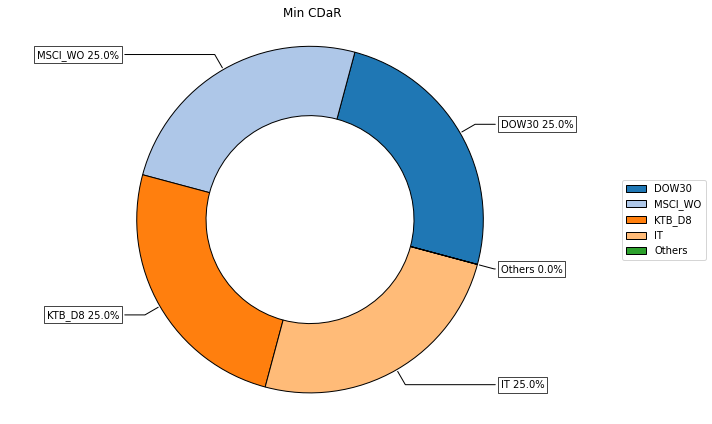

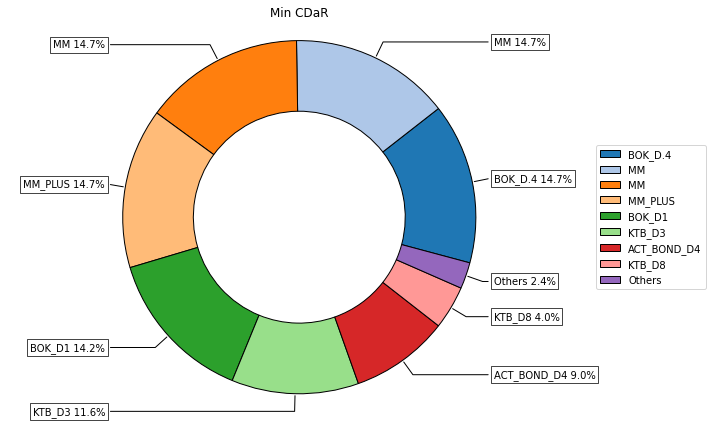

In [717]:
ax = plf.plot_pie(w=w, title='Min CDaR', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)

In [ ]:
ax = plf.plot_pie(w=w, title='Min CDaR', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)

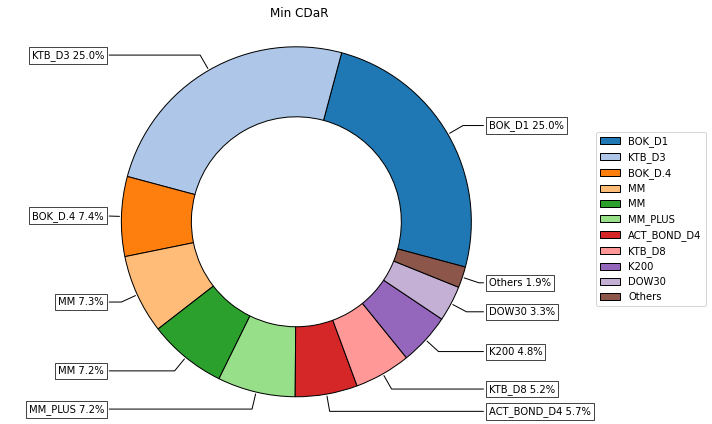

In [414]:
ax = plf.plot_pie(w=w, title='Min CDaR', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)

In [397]:
constraints

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,Classes,Asset class,Equity,>=,0.10,NaN,NaN,NaN,NaN
10,False,All Assets,NaN,NaN,<=,0.25,NaN,NaN,NaN,NaN
11,False,Classes,DC risky asset,Y,<=,0.40,NaN,NaN,NaN,NaN
12,False,Classes,Issuer,KINDEX,<=,0.40,NaN,NaN,NaN,NaN
13,False,Classes,Issuer,KODEX,<=,0.45,NaN,NaN,NaN,NaN
14,False,Classes,Issuer,TIGER,<=,0.50,NaN,NaN,NaN,NaN
15,False,Classes,Issuer,KBSTAR,<=,0.55,NaN,NaN,NaN,NaN
16,False,Classes,Issuer,KOSEF,<=,0.60,NaN,NaN,NaN,NaN
17,False,Classes,Issuer,ARIRANG,<=,0.65,NaN,NaN,NaN,NaN
18,False,Classes,Issuer,HANARO,<=,0.71,NaN,NaN,NaN,NaN


In [399]:
A

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.],
       [-1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -1., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -1., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -1., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0

In [365]:
A[:,-5]

array([-1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -1., -0., -0., -0.,
       -0., -1.,  0., -1.,  0.,  0.,  0.,  0.,  0.])

In [362]:
B.T

array([[-0.1 , -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25,
        -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25,
        -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25,
        -0.4 , -0.4 , -0.45, -0.5 , -0.55, -0.6 , -0.65, -0.71]])

In [367]:
asset_classes.iloc[-5]

Assets              A266370
Asset class          Equity
DC risky asset            Y
Issuer                KODEX
Strategy          Satellite
Name: 21, dtype: object

In [368]:
asset_classes

,Assets,Asset class,DC risky asset,Issuer,Strategy
0,A069500,Equity,Y,KODEX,Core
1,A105190,Equity,Y,KINDEX,Core
2,A102110,Equity,Y,TIGER,Core
3,A232080,Equity,Y,TIGER,Satellite
4,A278540,Equity,Y,KODEX,Core
5,A229200,Equity,Y,KODEX,Satellite
6,A196230,Fixed Income,N,KBSTAR,NaN
7,A130730,Fixed Income,N,KOSEF,NaN
8,A122260,Fixed Income,N,KOSEF,NaN
9,A139260,Equity,Y,TIGER,Core


In [849]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,A069500,A091160,A091170,A091180,A102110,A102780,A105190,A114260,A122260,A130730,...,A214980,A229200,A232080,A245340,A245710,A251350,A266370,A273130,A278540,A283580
0,1.175129e-04,1.933678e-03,4.019494e-04,7.510994e-05,1.164614e-04,0.000092,1.195394e-04,0.011179,0.036734,2.356589e-01,...,2.372777e-01,7.812839e-05,7.589698e-05,2.853846e-04,7.802721e-05,0.000248,0.000084,0.002135,1.121398e-04,1.035891e-03
1,2.663946e-14,3.319658e-03,1.123203e-14,7.463661e-15,2.778444e-14,0.014750,2.772147e-14,0.018163,0.250000,1.984756e-01,...,2.500000e-01,2.403870e-14,2.409632e-14,1.199466e-13,1.437408e-14,0.010075,0.005217,0.250000,4.115230e-14,7.658454e-14
2,5.248462e-14,3.627533e-13,2.010640e-14,1.628247e-14,5.395018e-14,0.017820,5.362214e-14,0.250000,0.250000,9.575955e-12,...,1.799859e-01,4.308598e-14,4.292237e-14,6.429979e-13,3.857211e-14,0.047477,0.001889,0.250000,8.094115e-14,1.067014e-13
3,6.493039e-14,3.211353e-12,2.497114e-14,2.087611e-14,6.676004e-14,0.027780,6.620166e-14,0.250000,0.250000,1.116079e-11,...,6.878829e-02,6.144998e-14,6.188593e-14,6.670535e-13,4.991379e-14,0.062513,0.001590,0.250000,1.001301e-13,1.412188e-13
4,7.888458e-14,3.239301e-12,2.922304e-14,2.574013e-14,8.095872e-14,0.044851,8.009707e-14,0.250000,0.194704,5.609233e-12,...,9.639813e-12,6.031138e-14,5.989666e-14,1.523889e-12,5.686315e-14,0.063480,0.006589,0.250000,1.199893e-13,1.578047e-13


C:\ProgramData\Anaconda3\envs\ra\lib\site-packages\riskfolio\PlotFunctions.py:337: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (ret - rf) / risk
C:\ProgramData\Anaconda3\envs\ra\lib\site-packages\riskfolio\PlotFunctions.py:359: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (ret - rf) / risk


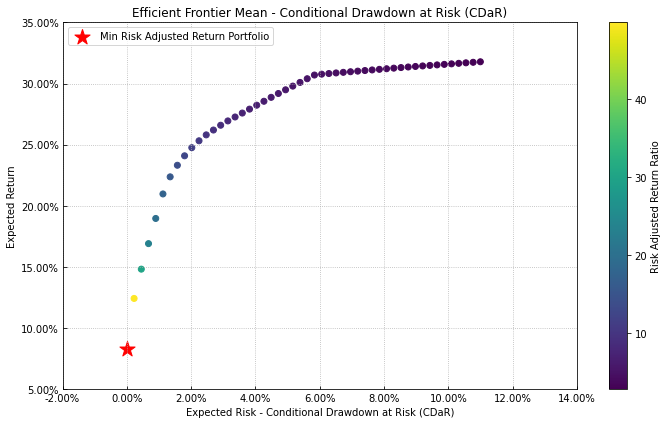

In [850]:
# Plotting the efficient frontier

label = 'Min Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = plf.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                       rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                       marker='*', s=16, c='r', height=6, width=10, ax=None)

In [28]:
frontier

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
A069500,0.000143,2.051975e-12,1.145116e-12,8.330681e-14,8.923227e-14,8.627233e-14,6.966394e-13,1.029008e-13,1.374196e-12,1.054772e-12,...,1.658484e-12,3.138366e-12,5.153259e-12,1.277158e-11,1.086571e-11,2.313867e-11,1.979184e-12,1.836828e-11,9.138958e-12,5.938167e-12
A091160,0.001980,2.844454e-02,1.140747e-11,1.206478e-13,9.171158e-14,9.544724e-14,7.913470e-13,1.312562e-13,1.640900e-12,1.206795e-12,...,7.232834e-01,7.540936e-01,7.849039e-01,8.157141e-01,8.465244e-01,8.773346e-01,9.081449e-01,9.387763e-01,9.693882e-01,1.000000e+00
A091170,0.000408,4.468999e-13,2.570314e-13,2.107916e-14,3.024796e-14,2.687059e-14,2.444850e-13,3.516644e-14,4.514685e-13,3.554609e-13,...,6.801389e-13,1.281780e-12,2.089589e-12,5.213943e-12,4.448192e-12,9.375342e-12,7.983646e-13,7.258348e-12,3.609951e-12,2.466705e-12
A091180,0.000084,2.393778e-13,1.844112e-13,1.796386e-14,1.968180e-14,1.877359e-14,1.697088e-13,2.589875e-14,3.187889e-13,2.488415e-13,...,6.239941e-13,1.165248e-12,1.714623e-12,4.446590e-12,3.578358e-12,7.826607e-12,6.606898e-13,6.397143e-12,3.187455e-12,2.217131e-12
A102110,0.000142,2.066205e-12,1.164513e-12,8.514100e-14,9.099264e-14,8.820515e-14,7.106303e-13,1.049461e-13,1.400102e-12,1.074616e-12,...,1.678558e-12,3.174606e-12,5.202174e-12,1.289907e-11,1.096623e-11,2.337411e-11,1.998731e-12,1.857649e-11,9.243833e-12,6.009555e-12
A102780,0.000113,6.128341e-02,9.023205e-02,1.157371e-12,6.112274e-13,4.953606e-13,3.868555e-12,5.521324e-13,6.549381e-12,5.728507e-12,...,2.472844e-12,4.797049e-12,8.411514e-12,2.067362e-11,1.881294e-11,3.953048e-11,3.538880e-12,3.117847e-11,1.533123e-11,9.912431e-12
A105190,0.000139,1.933764e-12,1.121183e-12,8.295727e-14,8.991503e-14,8.673953e-14,7.002786e-13,1.036517e-13,1.386595e-12,1.064452e-12,...,1.674824e-12,3.167983e-12,5.209285e-12,1.289617e-11,1.097880e-11,2.339960e-11,2.000462e-12,1.857749e-11,9.243830e-12,6.008155e-12
A114260,0.003714,3.403173e-01,1.089441e-11,5.879125e-13,6.117144e-13,5.226080e-13,4.527046e-12,6.781438e-13,6.996887e-12,5.499815e-12,...,1.223618e-12,2.310368e-12,3.382287e-12,8.772911e-12,7.209411e-12,1.579919e-11,1.365649e-12,1.301950e-11,6.473735e-12,4.542798e-12
A122260,0.032415,9.471059e-11,6.232395e-12,3.762284e-13,4.217075e-13,3.622360e-13,3.145785e-12,4.666981e-13,4.961409e-12,3.913948e-12,...,1.157398e-12,2.190121e-12,3.335887e-12,8.475732e-12,7.079518e-12,1.539928e-11,1.331645e-12,1.252344e-11,6.222280e-12,4.364686e-12
A130680,0.000161,2.240562e-13,2.856640e-13,2.575913e-14,2.959192e-14,2.631218e-14,2.041569e-13,3.070982e-14,3.830125e-13,3.144072e-13,...,7.751475e-13,1.495572e-12,2.660045e-12,6.357128e-12,5.559207e-12,1.143976e-11,9.734785e-13,8.403158e-12,4.134912e-12,2.733651e-12


In [30]:
frontier

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
A069500,0.000143,2.051975e-12,1.145116e-12,8.330681e-14,8.923227e-14,8.627233e-14,6.966394e-13,1.029008e-13,1.374196e-12,1.054772e-12,...,1.658484e-12,3.138366e-12,5.153259e-12,1.277158e-11,1.086571e-11,2.313867e-11,1.979184e-12,1.836828e-11,9.138958e-12,5.938167e-12
A091160,0.001980,2.844454e-02,1.140747e-11,1.206478e-13,9.171158e-14,9.544724e-14,7.913470e-13,1.312562e-13,1.640900e-12,1.206795e-12,...,7.232834e-01,7.540936e-01,7.849039e-01,8.157141e-01,8.465244e-01,8.773346e-01,9.081449e-01,9.387763e-01,9.693882e-01,1.000000e+00
A091170,0.000408,4.468999e-13,2.570314e-13,2.107916e-14,3.024796e-14,2.687059e-14,2.444850e-13,3.516644e-14,4.514685e-13,3.554609e-13,...,6.801389e-13,1.281780e-12,2.089589e-12,5.213943e-12,4.448192e-12,9.375342e-12,7.983646e-13,7.258348e-12,3.609951e-12,2.466705e-12
A091180,0.000084,2.393778e-13,1.844112e-13,1.796386e-14,1.968180e-14,1.877359e-14,1.697088e-13,2.589875e-14,3.187889e-13,2.488415e-13,...,6.239941e-13,1.165248e-12,1.714623e-12,4.446590e-12,3.578358e-12,7.826607e-12,6.606898e-13,6.397143e-12,3.187455e-12,2.217131e-12
A102110,0.000142,2.066205e-12,1.164513e-12,8.514100e-14,9.099264e-14,8.820515e-14,7.106303e-13,1.049461e-13,1.400102e-12,1.074616e-12,...,1.678558e-12,3.174606e-12,5.202174e-12,1.289907e-11,1.096623e-11,2.337411e-11,1.998731e-12,1.857649e-11,9.243833e-12,6.009555e-12
A102780,0.000113,6.128341e-02,9.023205e-02,1.157371e-12,6.112274e-13,4.953606e-13,3.868555e-12,5.521324e-13,6.549381e-12,5.728507e-12,...,2.472844e-12,4.797049e-12,8.411514e-12,2.067362e-11,1.881294e-11,3.953048e-11,3.538880e-12,3.117847e-11,1.533123e-11,9.912431e-12
A105190,0.000139,1.933764e-12,1.121183e-12,8.295727e-14,8.991503e-14,8.673953e-14,7.002786e-13,1.036517e-13,1.386595e-12,1.064452e-12,...,1.674824e-12,3.167983e-12,5.209285e-12,1.289617e-11,1.097880e-11,2.339960e-11,2.000462e-12,1.857749e-11,9.243830e-12,6.008155e-12
A114260,0.003714,3.403173e-01,1.089441e-11,5.879125e-13,6.117144e-13,5.226080e-13,4.527046e-12,6.781438e-13,6.996887e-12,5.499815e-12,...,1.223618e-12,2.310368e-12,3.382287e-12,8.772911e-12,7.209411e-12,1.579919e-11,1.365649e-12,1.301950e-11,6.473735e-12,4.542798e-12
A122260,0.032415,9.471059e-11,6.232395e-12,3.762284e-13,4.217075e-13,3.622360e-13,3.145785e-12,4.666981e-13,4.961409e-12,3.913948e-12,...,1.157398e-12,2.190121e-12,3.335887e-12,8.475732e-12,7.079518e-12,1.539928e-11,1.331645e-12,1.252344e-11,6.222280e-12,4.364686e-12
A130680,0.000161,2.240562e-13,2.856640e-13,2.575913e-14,2.959192e-14,2.631218e-14,2.041569e-13,3.070982e-14,3.830125e-13,3.144072e-13,...,7.751475e-13,1.495572e-12,2.660045e-12,6.357128e-12,5.559207e-12,1.143976e-11,9.734785e-13,8.403158e-12,4.134912e-12,2.733651e-12


In [58]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

In [59]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,WR,MDD,ADD,CDaR,UCI,EDaR
A069500,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
A091160,79.12%,100.00%,100.00%,100.00%,100.00%,100.00%,81.46%,75.12%,31.03%,30.36%,31.03%,38.36%,31.03%
A091170,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
A091180,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
A102110,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
A102780,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
A105190,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
A114260,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
A122260,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
A130680,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


In [62]:
import riskfolio.ConstraintsFunctions as cf

asset_classes = {'Assets': ['FB', 'GOOGL', 'NTFX', 'BAC', 'WFC', 'TLT', 'SHV'],
                 'Class 1': ['Equity', 'Equity', 'Equity', 'Equity', 'Equity',
                             'Fixed Income', 'Fixed Income'],
                 'Class 2': ['Technology', 'Technology', 'Technology',
                             'Financial', 'Financial', 'Treasury', 'Treasury'],}

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])

constraints = {'Disabled': [False, False, False, False, False, False, False],
               'Type': ['Classes', 'Classes', 'Assets', 'Assets', 'Classes',
                        'All Assets', 'Each asset in a class'],
               'Set': ['Class 1', 'Class 1', '', '', 'Class 2', '', 'Class 1'],
               'Position': ['Equity', 'Fixed Income', 'BAC', 'WFC', 'Financial',
                            '', 'Equity'],
               'Sign': ['<=', '<=', '<=', '<=', '>=', '>=', '>='],
               'Weight': [0.6, 0.5, 0.1, '', '', 0.02, ''],
               'Type Relative': ['', '', '', 'Assets', 'Classes', '', 'Assets'],
               'Relative Set': ['', '', '', '', 'Class 1', '', ''],
               'Relative': ['', '', '', 'FB', 'Fixed Income', '', 'TLT'],
               'Factor': ['', '', '', 1.2, 0.5, '', 0.4]}

constraints = pd.DataFrame(constraints)

display(asset_classes)
display(constraints)

,Assets,Class 1,Class 2
3,BAC,Equity,Financial
0,FB,Equity,Technology
1,GOOGL,Equity,Technology
2,NTFX,Equity,Technology
6,SHV,Fixed Income,Treasury
5,TLT,Fixed Income,Treasury
4,WFC,Equity,Financial


,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,Classes,Class 1,Equity,<=,0.6,,,,
1,False,Classes,Class 1,Fixed Income,<=,0.5,,,,
2,False,Assets,,BAC,<=,0.1,,,,
3,False,Assets,,WFC,<=,,Assets,,FB,1.2
4,False,Classes,Class 2,Financial,>=,,Classes,Class 1,Fixed Income,0.5
5,False,All Assets,,,>=,0.02,,,,
6,False,Each asset in a class,Class 1,Equity,>=,,Assets,,TLT,0.4


In [ ]:
def get_asset_classes(instruments):
    '''
    Riskfolio 패키지에서 제약조건을 걸 때 필요한 
    데이터 프레임 인스턴스 asset_classes를 instruments로부터 만들어
    반환한다.

    참조: https://riskfolio-lib.readthedocs.io/en/latest/constraints.html

    Parameters:
    instruments: pd.DataFrame
        - 투자 유니버스 중 거래가능한 종목들의 집합


    Returns:
    asset_classes: pd.DataFrame
        - ConstraintsFunctions.assets_constraints의 두 번째 파라미터 값
    '''
    asset_classes = instruments.rename(
        columns={
            'itemcode': 'Assets',
            'asset_class': 'Asset class',
            'dc_risky_asset': 'DC risky asset',
            'issuer': 'Issuer',
            'strategy': 'Strategy'
        })
    
    return asset_classes

In [61]:
import riskfolio.ConstraintsFunctions as cf

asset_classes = {'Assets': ['JCI','TGT','CMCSA','CPB','MO','APA','MMC','JPM',
                            'ZION','PSA','BAX','BMY','LUV','PCAR','TXT','TMO',
                            'DE','MSFT','HPQ','SEE','VZ','CNP','NI','T','BA'], 
                 'Industry': ['Consumer Discretionary','Consumer Discretionary',
                              'Consumer Discretionary', 'Consumer Staples',
                              'Consumer Staples','Energy','Financials',
                              'Financials','Financials','Financials',
                              'Health Care','Health Care','Industrials','Industrials',
                              'Industrials','Health care','Industrials',
                              'Information Technology','Information Technology',
                              'Materials','Telecommunications Services','Utilities',
                              'Utilities','Telecommunications Services','Financials']}

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])

constraints = {'Disabled': [False, False, False, False, False],
               'Type': ['All Assets', 'Classes', 'Classes', 'Classes',
                        'Classes'],
               'Set': ['', 'Industry', 'Industry', 'Industry', 'Industry'],
               'Position': ['', 'Financials', 'Utilities', 'Industrials',
                            'Consumer Discretionary'],
               'Sign': ['<=', '<=', '<=', '<=', '<='],
               'Weight': [0.10, 0.2, 0.2, 0.2, 0.2],
               'Type Relative': ['', '', '', '', ''],
               'Relative Set': ['', '', '', '', ''],
               'Relative': ['', '', '', '', ''],
               'Factor': ['', '', '', '', '']}

constraints = pd.DataFrame(constraints)

display(asset_classes)
display(constraints)

,Assets,Industry
5,APA,Energy
24,BA,Financials
10,BAX,Health Care
11,BMY,Health Care
2,CMCSA,Consumer Discretionary
21,CNP,Utilities
3,CPB,Consumer Staples
16,DE,Industrials
18,HPQ,Information Technology
0,JCI,Consumer Discretionary


,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,All Assets,,,<=,0.1,,,,
1,False,Classes,Industry,Financials,<=,0.2,,,,
2,False,Classes,Industry,Utilities,<=,0.2,,,,
3,False,Classes,Industry,Industrials,<=,0.2,,,,
4,False,Classes,Industry,Consumer Discretionary,<=,0.2,,,,


In [74]:
constraints

,risk_profile,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,2,False,Classes,Asset class,Equity,>=,0.01,NaN,NaN,NaN,NaN
1,2,False,Classes,Asset class,Equity,<=,0.03,NaN,NaN,NaN,NaN
2,2,False,Classes,Asset class,Alternative,<=,0.03,NaN,NaN,NaN,NaN
3,3,False,Classes,Asset class,Equity,>=,0.30,NaN,NaN,NaN,NaN
4,3,False,Classes,Asset class,Equity,<=,0.50,NaN,NaN,NaN,NaN
5,3,False,Classes,Asset class,Fixed Income,<=,0.70,NaN,NaN,NaN,NaN
6,3,False,Classes,Asset class,Alternative,<=,0.10,NaN,NaN,NaN,NaN
7,4,False,Classes,Asset class,Equity,>=,0.40,NaN,NaN,NaN,NaN
8,4,False,Classes,Asset class,Equity,<=,0.70,NaN,NaN,NaN,NaN
9,4,False,Classes,Asset class,Fixed Income,<=,0.50,NaN,NaN,NaN,NaN


In [70]:
asset_classes.columns

Index(['itemcode', 'asset_class', 'dc_risky_asset', 'issuer', 'strategy'], dtype='object')